## Load Dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./dataset/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('./dataset/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


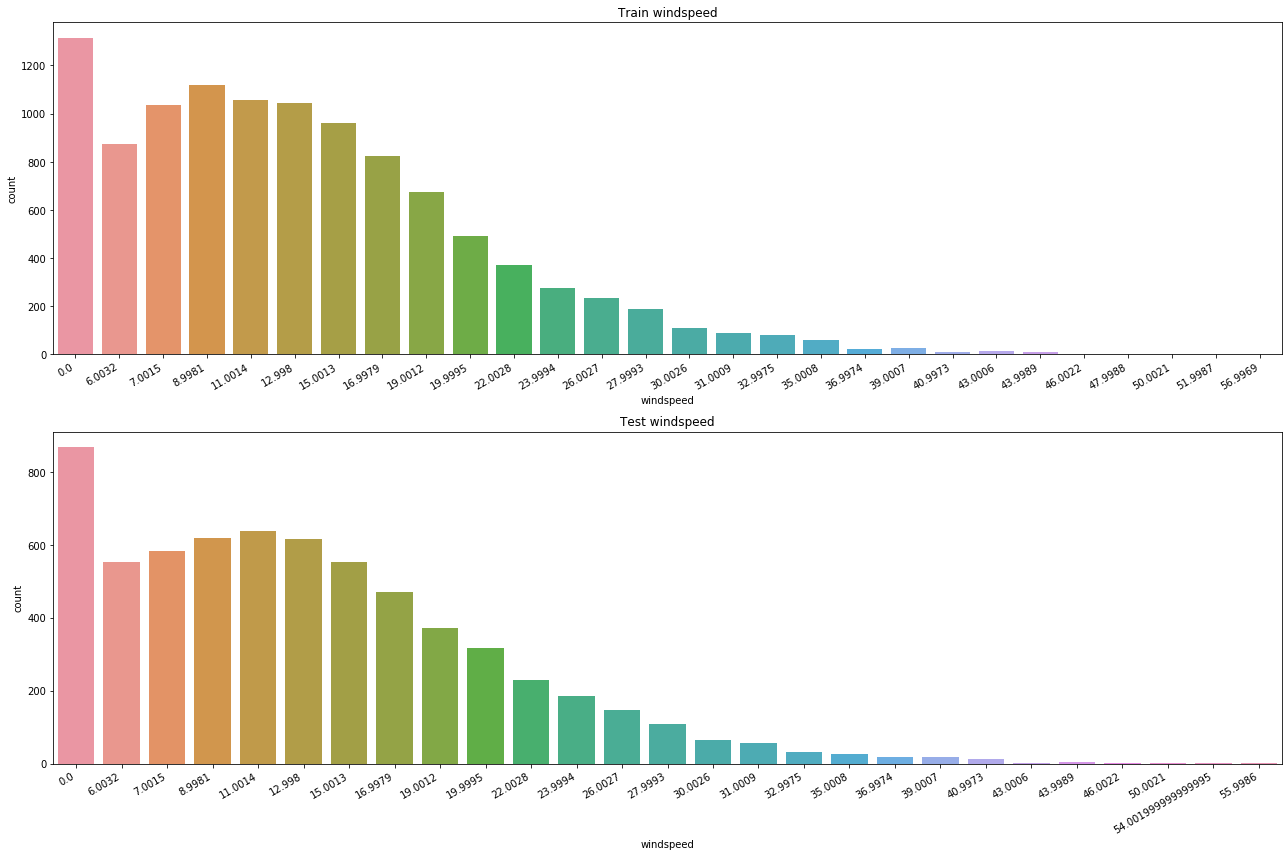

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(18, 12)

sns.countplot(data=train, x='windspeed', ax=ax1)
plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(title='Train windspeed')

sns.countplot(data=test, x='windspeed', ax=ax2)
plt.sca(ax2)
plt.xticks(rotation=30, ha='right')
plt.title('Test windspeed')
plt.tight_layout()

 - windspeed 항목에 0 값이 가장 많이 존재

In [9]:
trainWindZero = train.loc[train['windspeed'] == 0]
trainWindNotZero = train.loc[train['windspeed'] != 0]
print(trainWindZero.shape, trainWindNotZero.shape)

(1313, 19) (9573, 19)


In [10]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWindZero = data.loc[data['windspeed'] == 0]
    dataWindNotZero = data.loc[data['windspeed'] != 0]
    
    # windspeed를 예측할 특징 선택
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    dataWindNotZero['windspeed'] = dataWindNotZero['windspeed'].astype('str')
    
    rf_model = RandomForestClassifier()
    rf_model.fit(dataWindNotZero[wCol], dataWindNotZero['windspeed'])
    
    # 0으로 기록된 데이터의 windwpeed 예측
    zeroValues = rf_model.predict(X = dataWindZero[wCol])
    
    predictWindZero = dataWindZero
    predictWindNotZero = dataWindNotZero
    
    predictWindZero['windspeed'] = zeroValues
    
    data = predictWindNotZero.append(predictWindZero)
    
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

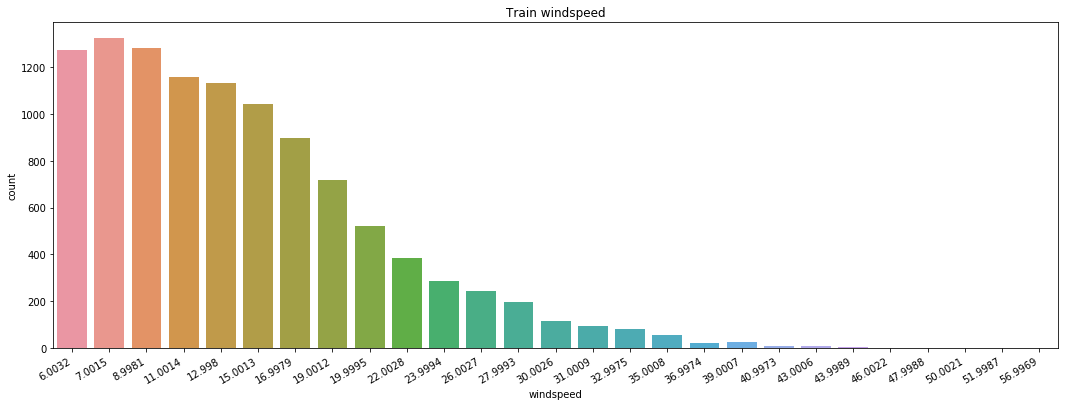

In [11]:
train = predict_windspeed(train)

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax)
plt.xticks(rotation=30, ha='right')
ax.set(title='Train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax)

## Feature Selection
 - 신호와 잡음 구분
 - feature가 많다고 해서 항상 좋은 성능을 보여주지는 않음
 - feature를 하나씩 추가하고 변경해가며 성능이 좋지 않은 feature 제거

In [12]:
# 연속형 변수 : temp, humidity, windspeed, atemp
# 범주형 변수 : season, holiday, workingday, weather, dayofweek, month, year, hour
# 범주형 변수의 type을 category로 변경
categorical_feature = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for name in categorical_feature:
    train[name] = train[name].astype('category')
    test[name] = test[name].astype('category')

In [13]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'year', 'hour', 'dayofweek', 'holiday', 'workingday']

In [14]:
X_train = train[feature_names]
X_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [15]:
X_test = test[feature_names]
X_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [16]:
y_train = train['count']

## Score
### RMSLE
 - 과대평가 된 항목보다는 과소평가 된 항목에 패널티 부여  
 - 오차를 제곱해서 평균한 값의 제곱근으로, 값이 작을 수록 정밀도 높음  
 - 0에 가까운 값이 나올 수록 정밀도가 높은 값
 
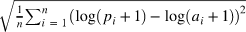
 - $n$ is the number of hours in the test set
 - $p_i$ is your predicted count
 - $a_i$ is the actual count
 - $\log(x)$ is the natural logarithm
 
![](./image/graph.png)

In [17]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual)**2
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Cross Validation

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest

In [19]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [20]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print('Score = {0:.5f}'.format(score))

Wall time: 29.3 s
Score = 0.33160


## Train

In [21]:
# train
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [22]:
# predict
predictions = model.predict(X_test)

[Text(0.5, 1.0, 'test')]

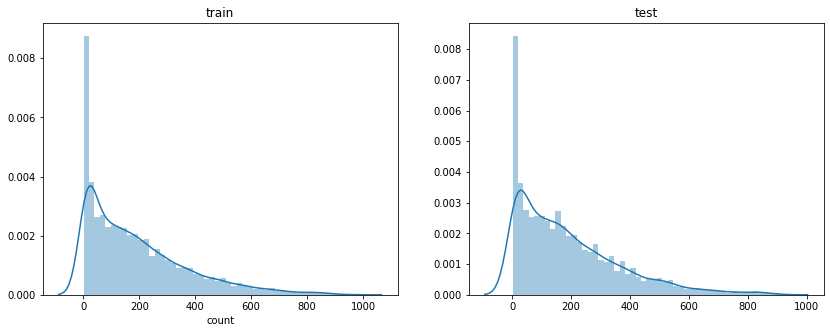

In [23]:
# visualization
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(14, 5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

## Submit

In [24]:
submit = pd.read_csv('./dataset/sampleSubmission.csv')
submit['count'] = predictions

submit.head()

,datetime,count
0,2011-01-20 00:00:00,12.50
1,2011-01-20 01:00:00,5.06
2,2011-01-20 02:00:00,3.92
3,2011-01-20 03:00:00,3.42
4,2011-01-20 04:00:00,3.09


In [25]:
submit.to_csv('./dataset/submission.csv', index=False)